# The Nurse Assignment Problem

This notebook is an example of how **Decision Optimization** can help to prescribe decisions for a complex constrained problem.

When you finish this tutorial, you'll have a foundational knowledge of _Prescriptive Analytics_.

>This notebook requires the Commercial Edition of CPLEX engines, which is included in the Default Python 3.6 XS + DO in Watson Studio.


Table of contents:

-  [Describe the business problem](#Describe-the-business-problem)
*  [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
*  [Use decision optimization](#Use-decision-optimization)
    *  [Step 1: Download the library](#Step-1:-Download-the-library)
    *  [Step 2: Set up the engines](#Step-2:-Set-up-the-prescriptive-engine)
    -  [Step 3: Model the data](#Step-3:-Model-the-data)
    *  [Step 4: Prepare the data](#Step-4:-Prepare-the-data)
    -  [Step 5: Set up the prescriptive model](#Step-5:-Set-up-the-prescriptive-model)
        * [Define the decision variables](#Define-the-decision-variables)
        * [Express the business constraints](#Express-the-business-constraints)
        * [Express the objective](#Express-the-objective)
        * [Solve with the Decision Optimization solve service](#Solve-with-the-Decision-Optimization-solve-service)
    *  [Step 6: Investigate the solution and run an example analysis](#Step-6:-Investigate-the-solution-and-then-run-an-example-analysis)
*  [Summary](#Summary)

****

## Describe the business problem

This notebook describes how to use CPLEX Modeling for Python together with *pandas* to
manage the assignment of nurses to shifts in a hospital.

Nurses must be assigned to hospital shifts in accordance with various skill and staffing constraints.

The goal of the model is to find an efficient balance between the different objectives:

* Minimize the overall cost of the plan and
* Assign shifts as fairly as possible.


## How  decision optimization can help

* Prescriptive analytics (decision optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate the complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.

## Use decision optimization

### Step 1: Import the docplex package 

This package is presintalled on Watson Studio.

In [1]:
import sys
import docplex.mp


### Step 2: Model the data

The input data consists of several tables:

* The Departments table lists all departments in the scope of the assignment.
* The Skills table list all skills.
* The Shifts table lists all shifts to be staffed. A shift contains a department, a day in the week, plus the start and end times.
* The Nurses table lists all nurses, identified by their names.
* The NurseSkills table gives the skills of each nurse.
* The SkillRequirements table lists the minimum number of persons required for a given department and skill.
* The NurseVacations table lists days off for each nurse.
* The NurseAssociations table lists pairs of nurses who wish to work together.
* The NurseIncompatibilities table lists pairs of nurses who do not want to work together.

#### Loading data from Excel with pandas

We load the data from an Excel file using *pandas*.
Each sheet is read into a separate *pandas* DataFrame.

In [2]:
# This notebook requires pandas to work
from io import StringIO
import json
import pandas as pd
from pandas import DataFrame

# Make sure that xlrd package, which is a pandas optional dependency, is installed
# This package is required for Excel I/O
try:
    import xlrd
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install xlrd 
    else:
        !pip install --user xlrd

In [3]:

# Use pandas to read the file, one tab for each table.
nurse_xls_file = pd.ExcelFile("https://dataplatform.cloud.ibm.com/data/exchange-api/v1/entries/2505b070a22403aac9f84884d315219e/data?accessKey=38990e0e17b15be6df05d384006a1d06")
df_skills = nurse_xls_file.parse('Skills')
df_depts  = nurse_xls_file.parse('Departments')
df_shifts = nurse_xls_file.parse('Shifts')
# Rename df_shifts index
df_shifts.index.name = 'shiftId'

# Index is column 0: name
df_nurses = nurse_xls_file.parse('Nurses', header=0, index_col=0)
df_nurse_skilles = nurse_xls_file.parse('NurseSkills')
df_vacations = nurse_xls_file.parse('NurseVacations')
df_associations = nurse_xls_file.parse('NurseAssociations')
df_incompatibilities = nurse_xls_file.parse('NurseIncompatibilities')

# Display the nurses dataframe
print("#nurses = {}".format(len(df_nurses)))
print("#shifts = {}".format(len(df_shifts)))
print("#vacations = {}".format(len(df_vacations)))

#nurses = 32
#shifts = 41
#vacations = 59


In addition, we introduce some extra global data:

* The maximum work time for each nurse.
* The maximum and minimum number of shifts worked by a nurse in a week.

In [4]:
# maximum work time (in hours)
max_work_time = 40

# maximum number of shifts worked in a week.
max_nb_shifts = 5

Shifts are stored in a separate DataFrame.

In [5]:
df_shifts

,department,day,start_time,end_time,min_req,max_req
shiftId,,,,,,
0,Emergency,Monday,2,8,3,5
1,Emergency,Monday,8,12,4,7
2,Emergency,Monday,12,18,2,5
3,Emergency,Monday,18,2,3,7
4,Consultation,Monday,8,12,10,13
5,Consultation,Monday,12,18,8,12
6,Cardiac Care,Monday,8,12,10,13
7,Cardiac Care,Monday,12,18,8,12
8,Emergency,Tuesday,8,12,4,7


### Step 3: Prepare the data

We need to precompute additional data for shifts. 
For each shift, we need the start time and end time expressed in hours, counting from the beginning of the week: Monday 8am is converted to 8, Tuesday 8am is converted to 24+8 = 32, and so on.

#### Sub-step #1
We start by adding an extra column `dow` (day of week) which converts the string "day" into an integer in 0..6 (Monday is 0, Sunday is 6).

In [6]:
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
day_of_weeks = dict(zip(days, range(7)))

# utility to convert a day string e.g. "Monday" to an integer in 0..6
def day_to_day_of_week(day):
    return day_of_weeks[day.strip().lower()]

# for each day name, we normalize it by stripping whitespace and converting it to lowercase
# " Monday" -> "monday"
df_shifts["dow"] = df_shifts.day.apply(day_to_day_of_week)
df_shifts

,department,day,start_time,end_time,min_req,max_req,dow
shiftId,,,,,,,
0,Emergency,Monday,2,8,3,5,0
1,Emergency,Monday,8,12,4,7,0
2,Emergency,Monday,12,18,2,5,0
3,Emergency,Monday,18,2,3,7,0
4,Consultation,Monday,8,12,10,13,0
5,Consultation,Monday,12,18,8,12,0
6,Cardiac Care,Monday,8,12,10,13,0
7,Cardiac Care,Monday,12,18,8,12,0
8,Emergency,Tuesday,8,12,4,7,1


#### Sub-step #2 : Compute the absolute start time of each shift.

Computing the start time in the week is easy: just add `24*dow` to column `start_time`. The result is stored in a new column `wstart`.

In [7]:
df_shifts["wstart"] = df_shifts.start_time + 24 * df_shifts.dow

#### Sub-Step #3 : Compute the absolute end time of each shift.

Computing the absolute end time is a little more complicated as certain shifts span across midnight. For example, Shift #3 starts on Monday at 18:00 and ends Tuesday at 2:00 AM. The absolute end time of Shift #3 is 26, not 2.
The general rule for computing absolute end time is:

`abs_end_time = end_time + 24 * dow + (start_time>= end_time ? 24 : 0)`

Again, we use *pandas* to add a new calculated column `wend`. This is done by using the *pandas* `apply` method with an anonymous `lambda` function over rows. The `raw=True` parameter prevents the creation of a *pandas* Series for each row, which improves the performance significantly on large data sets.

In [8]:
# an auxiliary function to calculate absolute end time of a shift
def calculate_absolute_endtime(start, end, dow):
    return 24*dow + end + (24 if start>=end else 0)

# store the results in a new column
df_shifts["wend"] = df_shifts.apply(lambda row: calculate_absolute_endtime(
        row.start_time, row.end_time, row.dow), axis=1, raw=True)

#### Sub-step #4 : Compute the duration of each shift.

Computing the duration of each shift is now a straightforward difference of columns. The result is stored in column `duration`.

In [9]:
df_shifts["duration"] = df_shifts.wend - df_shifts.wstart

#### Sub-step #5 : Compute the minimum demand for each shift.

Minimum demand is the product of duration (in hours) by the minimum required number of nurses. Thus, in number of 
nurse-hours, this demand is stored in another new column `min_demand`.

Finally, we display the updated shifts DataFrame with all calculated columns.

In [10]:
# also compute minimum demand in nurse-hours
df_shifts["min_demand"] = df_shifts.min_req * df_shifts.duration

# finally check the modified shifts dataframe
df_shifts

,department,day,start_time,end_time,min_req,max_req,dow,wstart,wend,duration,min_demand
shiftId,,,,,,,,,,,
0,Emergency,Monday,2,8,3,5,0,2,8,6,18
1,Emergency,Monday,8,12,4,7,0,8,12,4,16
2,Emergency,Monday,12,18,2,5,0,12,18,6,12
3,Emergency,Monday,18,2,3,7,0,18,26,8,24
4,Consultation,Monday,8,12,10,13,0,8,12,4,40
5,Consultation,Monday,12,18,8,12,0,12,18,6,48
6,Cardiac Care,Monday,8,12,10,13,0,8,12,4,40
7,Cardiac Care,Monday,12,18,8,12,0,12,18,6,48
8,Emergency,Tuesday,8,12,4,7,1,32,36,4,16


### Step 4: Set up the prescriptive model

In [11]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python version 3.6.8, located at: /opt/conda/envs/Python36/bin/python
* docplex is present, version is (2, 10, 150)
* CPLEX library is present, version is 12.9.0.1, located at: /opt/conda/envs/Python36/lib/python3.6/site-packages
* pandas is present, version is 0.24.1


#### Create the DOcplex model
The model contains all the business constraints and defines the objective.

We now use CPLEX Modeling for Python to build a Mixed Integer Programming (MIP) model for this problem.

In [12]:
from docplex.mp.model import Model
mdl = Model(name="nurses")

#### Define the decision variables

For each (nurse, shift) pair, we create one binary variable that is equal to 1 when the nurse is assigned to the shift.

We use the `binary_var_matrix` method of class `Model`, as each binary variable is indexed by _two_ objects: one nurse and one shift.

In [13]:
# first global collections to iterate upon
all_nurses = df_nurses.index.values
all_shifts = df_shifts.index.values

# the assignment variables.
assigned = mdl.binary_var_matrix(keys1=all_nurses, keys2=all_shifts, name="assign_%s_%s")

#### Express the business constraints

#####  Overlapping shifts

Some shifts overlap in time, and thus cannot be assigned to the same nurse.
To check whether two shifts overlap in time, we start by ordering all shifts with respect to their *wstart* and *duration* properties. Then, for each shift, we iterate over the subsequent shifts in this ordered list to easily compute the subset of overlapping shifts.

We use *pandas* operations to implement this algorithm. But first, we organize all decision variables in a DataFrame.

For convenience, we also organize the decision variables in a pivot table with *nurses* as row index and *shifts* as columns. The *pandas* *unstack* operation does this.

In [14]:
# Organize decision variables in a DataFrame
df_assigned = DataFrame({'assigned': assigned})
df_assigned.index.names=['all_nurses', 'all_shifts']

# Re-organize the Data Frame as a pivot table with nurses as row index and shifts as columns:
df_assigned_pivot = df_assigned.unstack(level='all_shifts')

# Create a pivot using nurses and shifts index as dimensions
df_assigned_pivot = df_assigned.reset_index().pivot(index='all_nurses', columns='all_shifts', values='assigned')

# Display first rows of the pivot table
df_assigned_pivot.head()

all_shifts,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
all_nurses,,,,,,,,,,,,,,,,,,,,,
Anne,assign_Anne_0,assign_Anne_1,assign_Anne_2,assign_Anne_3,assign_Anne_4,assign_Anne_5,assign_Anne_6,assign_Anne_7,assign_Anne_8,assign_Anne_9,...,assign_Anne_31,assign_Anne_32,assign_Anne_33,assign_Anne_34,assign_Anne_35,assign_Anne_36,assign_Anne_37,assign_Anne_38,assign_Anne_39,assign_Anne_40
Bethanie,assign_Bethanie_0,assign_Bethanie_1,assign_Bethanie_2,assign_Bethanie_3,assign_Bethanie_4,assign_Bethanie_5,assign_Bethanie_6,assign_Bethanie_7,assign_Bethanie_8,assign_Bethanie_9,...,assign_Bethanie_31,assign_Bethanie_32,assign_Bethanie_33,assign_Bethanie_34,assign_Bethanie_35,assign_Bethanie_36,assign_Bethanie_37,assign_Bethanie_38,assign_Bethanie_39,assign_Bethanie_40
Betsy,assign_Betsy_0,assign_Betsy_1,assign_Betsy_2,assign_Betsy_3,assign_Betsy_4,assign_Betsy_5,assign_Betsy_6,assign_Betsy_7,assign_Betsy_8,assign_Betsy_9,...,assign_Betsy_31,assign_Betsy_32,assign_Betsy_33,assign_Betsy_34,assign_Betsy_35,assign_Betsy_36,assign_Betsy_37,assign_Betsy_38,assign_Betsy_39,assign_Betsy_40
Cathy,assign_Cathy_0,assign_Cathy_1,assign_Cathy_2,assign_Cathy_3,assign_Cathy_4,assign_Cathy_5,assign_Cathy_6,assign_Cathy_7,assign_Cathy_8,assign_Cathy_9,...,assign_Cathy_31,assign_Cathy_32,assign_Cathy_33,assign_Cathy_34,assign_Cathy_35,assign_Cathy_36,assign_Cathy_37,assign_Cathy_38,assign_Cathy_39,assign_Cathy_40
Cecilia,assign_Cecilia_0,assign_Cecilia_1,assign_Cecilia_2,assign_Cecilia_3,assign_Cecilia_4,assign_Cecilia_5,assign_Cecilia_6,assign_Cecilia_7,assign_Cecilia_8,assign_Cecilia_9,...,assign_Cecilia_31,assign_Cecilia_32,assign_Cecilia_33,assign_Cecilia_34,assign_Cecilia_35,assign_Cecilia_36,assign_Cecilia_37,assign_Cecilia_38,assign_Cecilia_39,assign_Cecilia_40


We create a DataFrame representing a list of shifts sorted by *"wstart"* and *"duration"*.
This sorted list will be used to easily detect overlapping shifts.

Note that indices are reset after sorting so that the DataFrame can be indexed with respect to
the index in the sorted list and not the original unsorted list. This is the purpose of the *reset_index()*
operation which also adds a new column named *"shiftId"* with the original index.

In [15]:
# Create a Data Frame representing a list of shifts sorted by wstart and duration.
# One keeps only the three relevant columns: 'shiftId', 'wstart' and 'wend' in the resulting Data Frame 
df_sorted_shifts = df_shifts.sort_values(['wstart','duration']).reset_index()[['shiftId', 'wstart', 'wend']]

# Display the first rows of the newly created Data Frame
df_sorted_shifts.head()

,shiftId,wstart,wend
0,0,2,8
1,1,8,12
2,4,8,12
3,6,8,12
4,2,12,18


Next, we state that for any pair of shifts that overlap in time, a nurse can be assigned to only one of the two.

In [16]:
number_of_incompatible_shift_constraints = 0
for shift in df_sorted_shifts.itertuples():
    # Iterate over following shifts
    # 'shift[0]' contains the index of the current shift in the df_sorted_shifts Data Frame
    for shift_2 in df_sorted_shifts.iloc[shift[0] + 1:].itertuples():
        if (shift_2.wstart < shift.wend):
            # Iterate over all nurses to force incompatible assignment for the current pair of overlapping shifts
            for nurse_assignments in df_assigned_pivot[[shift.shiftId, shift_2.shiftId]].itertuples():                
                # this is actually a logical OR
                mdl.add_constraint(nurse_assignments[1] + nurse_assignments[2] <= 1)
                number_of_incompatible_shift_constraints += 1
        else:
            # No need to test overlap with following shifts
            break
print("#incompatible shift constraints: {}".format(number_of_incompatible_shift_constraints))

#incompatible shift constraints: 640


##### Vacations

When the nurse is on vacation, he cannot be assigned to any shift starting that day.

We use the *pandas* *merge* operation to create a join between the *"df_vacations"*, *"df_shifts"*, and *"df_assigned"* DataFrames. Each row of the resulting DataFrame contains the assignment decision variable corresponding to the matching (nurse, shift) pair.

In [17]:
# Add 'day of week' column to vacations Data Frame
df_vacations['dow'] = df_vacations.day.apply(day_to_day_of_week)

# Join 'df_vacations', 'df_shifts' and 'df_assigned' Data Frames to create the list of 'forbidden' assigments.
# The 'reset_index()' function is invoked to move 'shiftId' index as a column in 'df_shifts' Data Frame, and
# to move the index pair ('all_nurses', 'all_shifts') as columns in 'df_assigned' Data Frame.
# 'reset_index()' is invoked so that a join can be performed between Data Frame, based on column names.
df_assigned_reindexed = df_assigned.reset_index()
df_vacation_forbidden_assignments = df_vacations.merge(df_shifts.reset_index()[['dow', 'shiftId']]).merge(
    df_assigned_reindexed, left_on=['nurse', 'shiftId'], right_on=['all_nurses', 'all_shifts'])

# Here are the first few rows of the resulting Data Frames joins
df_vacation_forbidden_assignments.head()

,nurse,day,dow,shiftId,all_nurses,all_shifts,assigned
0,Anne,Friday,4,28,Anne,28,assign_Anne_28
1,Anne,Friday,4,29,Anne,29,assign_Anne_29
2,Anne,Friday,4,30,Anne,30,assign_Anne_30
3,Anne,Friday,4,31,Anne,31,assign_Anne_31
4,Anne,Friday,4,32,Anne,32,assign_Anne_32


In [18]:
for forbidden_assignment in df_vacation_forbidden_assignments.itertuples():
    # to forbid an assignment just set the variable to zero.
    mdl.add_constraint(forbidden_assignment.assigned == 0)
print("# vacation forbids: {} assignments".format(len(df_vacation_forbidden_assignments)))

# vacation forbids: 342 assignments


##### Associations

Some pairs of nurses get along particularly well, so we wish to assign them together as a team. In other words, for every such couple and for each shift, both assignment variables should always be equal.
Either both nurses work the shift, or both do not.

In the same way we modeled *vacations*, we use the *pandas* merge operation to create a DataFrame for which each row contains the pair of nurse-shift assignment decision variables matching each association.

In [19]:
# Join 'df_assignment' Data Frame twice, based on associations to get corresponding decision variables pairs for all shifts
# The 'suffixes' parameter in the second merge indicates our preference for updating the name of columns that occur both
# in the first and second argument Data Frames (in our case, these columns are 'all_nurses' and 'assigned').
df_preferred_assign = df_associations.merge(
    df_assigned_reindexed, left_on='nurse1', right_on='all_nurses').merge(
    df_assigned_reindexed, left_on=['nurse2', 'all_shifts'], right_on=['all_nurses', 'all_shifts'], suffixes=('_1','_2'))

# Here are the first few rows of the resulting Data Frames joins
df_preferred_assign.head()

,nurse1,nurse2,all_nurses_1,all_shifts,assigned_1,all_nurses_2,assigned_2
0,Isabelle,Dee,Isabelle,0,assign_Isabelle_0,Dee,assign_Dee_0
1,Isabelle,Dee,Isabelle,1,assign_Isabelle_1,Dee,assign_Dee_1
2,Isabelle,Dee,Isabelle,2,assign_Isabelle_2,Dee,assign_Dee_2
3,Isabelle,Dee,Isabelle,3,assign_Isabelle_3,Dee,assign_Dee_3
4,Isabelle,Dee,Isabelle,4,assign_Isabelle_4,Dee,assign_Dee_4


The associations constraint can now easily be formulated by iterating on the rows of the *"df_preferred_assign"* DataFrame.

In [20]:
for preferred_assign in df_preferred_assign.itertuples():
    mdl.add_constraint(preferred_assign.assigned_1 == preferred_assign.assigned_2)

##### Incompatibilities

Similarly, certain pairs of nurses do not get along well, and we want to avoid having them together on a shift.
In other terms, for each shift, both nurses of an incompatible pair cannot be assigned together to the sift. Again, we state a logical OR between the two assignments: at most one nurse from the pair can work the shift.

We first create a DataFrame whose rows contain pairs of invalid assignment decision variables, using the same *pandas* `merge` operations as in the previous step.

In [21]:
# Join assignment Data Frame twice, based on incompatibilities Data Frame to get corresponding decision variables pairs
#  for all shifts
df_incompatible_assign = df_incompatibilities.merge(
    df_assigned_reindexed, left_on='nurse1', right_on='all_nurses').merge(
    df_assigned_reindexed, left_on=['nurse2', 'all_shifts'], right_on=['all_nurses', 'all_shifts'], suffixes=('_1','_2'))

# Here are the first few rows of the resulting Data Frames joins
df_incompatible_assign.head()

,nurse1,nurse2,all_nurses_1,all_shifts,assigned_1,all_nurses_2,assigned_2
0,Patricia,Patrick,Patricia,0,assign_Patricia_0,Patrick,assign_Patrick_0
1,Patricia,Patrick,Patricia,1,assign_Patricia_1,Patrick,assign_Patrick_1
2,Patricia,Patrick,Patricia,2,assign_Patricia_2,Patrick,assign_Patrick_2
3,Patricia,Patrick,Patricia,3,assign_Patricia_3,Patrick,assign_Patrick_3
4,Patricia,Patrick,Patricia,4,assign_Patricia_4,Patrick,assign_Patrick_4


The incompatibilities constraint can now easily be formulated, by iterating on the rows of the *"df_incompatible_assign"* DataFrame.

In [22]:
for incompatible_assign in df_incompatible_assign.itertuples():
    mdl.add_constraint(incompatible_assign.assigned_1 + incompatible_assign.assigned_2 <= 1)

##### Constraints on work time

Regulations force constraints on the total work time over a week;
and we compute this total work time in a new variable. We store the variable in an extra column in the nurse DataFrame.

The variable is declared as _continuous_ though it contains only integer values. This is done to avoid adding unnecessary integer variables for the _branch and bound_ algorithm. 
These variables are not true decision variables; they are used to express work constraints.

From a *pandas* perspective, we apply a function over the rows of the nurse DataFrame to create this variable and store it into a new column of the DataFrame.

In [23]:
# auxiliary function to create worktime variable from a row
def make_var(row, varname_fmt):
    return mdl.continuous_var(name=varname_fmt % row.name, lb=0)

# apply the function over nurse rows and store result in a new column
df_nurses["worktime"] = df_nurses.apply(lambda r: make_var(r, "worktime_%s"), axis=1)

# display nurse dataframe
df_nurses

,seniority,qualification,pay_rate,worktime
name,,,,
Anne,11,1,25,worktime_Anne
Bethanie,4,5,28,worktime_Bethanie
Betsy,2,2,17,worktime_Betsy
Cathy,2,2,17,worktime_Cathy
Cecilia,9,5,38,worktime_Cecilia
Chris,11,4,38,worktime_Chris
Cindy,5,2,21,worktime_Cindy
David,1,2,15,worktime_David
Debbie,7,2,24,worktime_Debbie


###### Define total work time

Work time variables must be constrained to be equal to the sum of hours actually worked.

We use the *pandas* *groupby* operation to collect all assignment decision variables for each nurse in a separate series. Then, we iterate over nurses to post a constraint calculating the actual worktime for each nurse as the dot product of the series of nurse-shift assignments with the series of shift durations.

In [24]:
# Use pandas' groupby operation to enforce constraint calculating worktime for each nurse as the sum of all assigned
#  shifts times the duration of each shift
for nurse, nurse_assignments in df_assigned.groupby(level='all_nurses'):
    mdl.add_constraint(df_nurses.worktime[nurse] == mdl.dot(nurse_assignments.assigned, df_shifts.duration))
                       
# print model information and check we now have 32 extra continuous variables
mdl.print_information()

Model: nurses
 - number of variables: 1344
   - binary=1312, integer=0, continuous=32
 - number of constraints: 1547
   - linear=1547
 - parameters: defaults
 - problem type is: MILP


###### Maximum work time

For each nurse, we add a constraint to enforce the maximum work time for a week.
Again we use the `apply` method, this time with an anonymous lambda function.

In [25]:
# we use pandas' apply() method to set an upper bound on all worktime variables.
def set_max_work_time(v):
    v.ub = max_work_time
    # Optionally: return a string for fancy display of the constraint in the Output cell
    return str(v) + ' <= ' + str(v.ub)

df_nurses["worktime"].apply(convert_dtype=False, func=set_max_work_time)

name
Anne            worktime_Anne <= 40
Bethanie    worktime_Bethanie <= 40
Betsy          worktime_Betsy <= 40
Cathy          worktime_Cathy <= 40
Cecilia      worktime_Cecilia <= 40
Chris          worktime_Chris <= 40
Cindy          worktime_Cindy <= 40
David          worktime_David <= 40
Debbie        worktime_Debbie <= 40
Dee              worktime_Dee <= 40
Gloria        worktime_Gloria <= 40
Isabelle    worktime_Isabelle <= 40
Jane            worktime_Jane <= 40
Janelle      worktime_Janelle <= 40
Janice        worktime_Janice <= 40
Jemma          worktime_Jemma <= 40
Joan            worktime_Joan <= 40
Joyce          worktime_Joyce <= 40
Jude            worktime_Jude <= 40
Julie          worktime_Julie <= 40
Juliet        worktime_Juliet <= 40
Kate            worktime_Kate <= 40
Nancy          worktime_Nancy <= 40
Nathalie    worktime_Nathalie <= 40
Nicole        worktime_Nicole <= 40
Patricia    worktime_Patricia <= 40
Patrick      worktime_Patrick <= 40
Roberta      worktime_R

##### Minimum requirement for shifts

Each shift requires a minimum number of nurses. 
For each shift, the sum over all nurses of assignments to this shift
must be greater than the minimum requirement.

The *pandas* *groupby* operation is invoked to collect all assignment decision variables for each shift in a separate series. Then, we iterate over shifts to post the constraint enforcing the minimum number of nurse assignments for each shift.

In [26]:
# Use pandas' groupby operation to enforce minimum requirement constraint for each shift
for shift, shift_nurses in df_assigned.groupby(level='all_shifts'):
    mdl.add_constraint(mdl.sum(shift_nurses.assigned) >= df_shifts.min_req[shift])

#### Express the objective

The objective mixes different (and contradictory) KPIs. 

The first KPI is the total salary cost, computed as the sum of work times over all nurses, weighted by pay rate.

We compute this KPI as an expression from the variables we previously defined by using the panda summation over the DOcplex objects.

In [27]:
# again leverage pandas to create a series of expressions: costs of each nurse
total_salary_series = df_nurses.worktime * df_nurses.pay_rate

# compute global salary cost using pandas sum()
# Note that the result is a DOcplex expression: DOcplex if fully compatible with pandas
total_salary_cost = total_salary_series.sum()
mdl.add_kpi(total_salary_cost, "Total salary cost")

DecisionKPI(name=Total salary cost,expr=25worktime_Anne+28worktime_Bethanie+17worktime_Betsy+17worktime_..)

##### Minimizing salary cost

In a preliminary version of the model, we minimize the total salary cost. This is accomplished
using the `Model.minimize()` method.

In [28]:
mdl.minimize(total_salary_cost)
mdl.print_information()

Model: nurses
 - number of variables: 1344
   - binary=1312, integer=0, continuous=32
 - number of constraints: 1588
   - linear=1588
 - parameters: defaults
 - problem type is: MILP


#### Solve with the Decision Optimization solve service

Now we have everything we need to solve the model, using `Model.solve()`. 

In [29]:
# Set Cplex mipgap to 1e-5 to enforce precision to be of the order of a unit (objective value magnitude is ~1e+5).
mdl.parameters.mip.tolerances.mipgap = 1e-5

s = mdl.solve(log_output=True)
assert s, "solve failed"
mdl.report()

CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 2
CPXPARAM_MIP_Tolerances_MIPGap                   1.0000000000000001e-05
Tried aggregator 2 times.
MIP Presolve eliminated 997 rows and 379 columns.
MIP Presolve modified 90 coefficients.
Aggregator did 41 substitutions.
Reduced MIP has 550 rows, 922 columns, and 2862 nonzeros.
Reduced MIP has 892 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.68 ticks)
Probing time = 0.00 sec. (0.50 ticks)
Tried aggregator 1 time.
Reduced MIP has 550 rows, 922 columns, and 2862 nonzeros.
Reduced MIP has 892 binaries, 30 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.03 ticks)
Probing time = 0.00 sec. (0.50 ticks)
Clique table members: 479.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 2 threads.
Root relaxation solution time = 0.01 sec. (4.56 ticks)

        Nodes            

### Step 5: Investigate the solution and then run an example analysis

We take advantage of *pandas* to analyze the results. First we store the solution values of the assignment variables into a new *pandas* Series.

Calling `solution_value` on a DOcplex variable returns its value in the solution (provided the model has been successfully solved).

In [30]:
# Create a pandas Series containing actual shift assignment decision variables value
s_assigned = df_assigned.assigned.apply(lambda v: v.solution_value)

# Create a pivot table by (nurses, shifts), using pandas' "unstack" method to transform the 'all_shifts' row index
#  into columns
df_res = s_assigned.unstack(level='all_shifts')

# Display the first few rows of the resulting pivot table
df_res.head()

all_shifts,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
all_nurses,,,,,,,,,,,,,,,,,,,,,
Anne,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bethanie,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Betsy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cathy,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Cecilia,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Analyzing how worktime is distributed

Let's analyze how worktime is distributed among nurses. 

First, we compute the global average work time as the total minimum requirement in hours, divided by number of nurses.

In [31]:
s_demand  = df_shifts.min_req * df_shifts.duration
total_demand = s_demand.sum()
avg_worktime = total_demand / float(len(all_nurses))
print("* theoretical average work time is {0:g} h".format(avg_worktime))

* theoretical average work time is 39 h


Let's analyze the series of deviations to the average, stored in a *pandas* Series.

In [32]:
# a pandas series of worktimes solution values
s_worktime = df_nurses.worktime.apply(lambda v: v.solution_value)

# returns a new series computed as deviation from average
s_to_mean = s_worktime - avg_worktime

# take the absolute value
s_abs_to_mean = s_to_mean.apply(abs)


total_to_mean = s_abs_to_mean.sum()
print("* the sum of absolute deviations from mean is {}".format(total_to_mean))

* the sum of absolute deviations from mean is 58.0


To see how work time is distributed among nurses, print a histogram of work time values.
Note that, as all time data are integers, work times in the solution can take only integer values.

Text(0.5, 0, 'worktime')

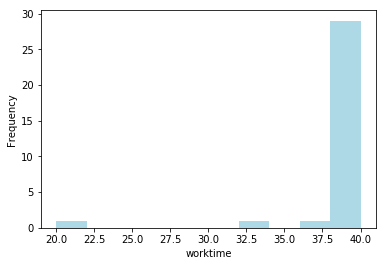

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

# we can also plot as a histogram the distribution of worktimes
s_worktime.plot.hist(color='LightBlue')
plt.xlabel("worktime")

#### How shifts are distributed

Let's now analyze the solution from the _number of shifts_ perspective.
How many shifts does each nurse work? Are these shifts fairly distributed amongst nurses?

We compute a new column in our result DataFrame for the number of shifts worked,
by summing rows (the *"axis=1"* argument in the *sum()* call indicates to *pandas* that each sum is performed by row instead of column):

Text(0, 0.5, '#shifts worked')

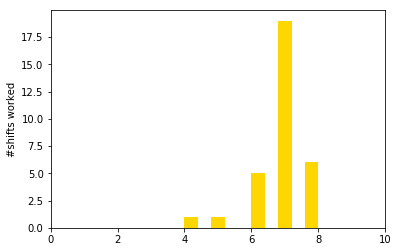

In [34]:
# a pandas series of #shifts worked
df_worked = df_res[all_shifts].sum(axis=1)
df_res["worked"] = df_worked

df_worked.plot.hist(color="gold", xlim=(0,10))
plt.ylabel("#shifts worked")

We see that one nurse works significantly fewer shifts than others do. What is the average number of shifts worked by a nurse? This is equal to the total demand divided by the number of nurses.

Of course, this yields a fractional number of shifts that is not practical, but nonetheless will help us quantify
the _fairness_ in shift distribution.

In [35]:
avg_worked = df_shifts["min_req"].sum() / float(len(all_nurses))
print("-- expected avg #shifts worked is {}".format(avg_worked))

worked_to_avg = df_res["worked"] - avg_worked
total_to_mean = worked_to_avg.apply(abs).sum()
print("-- total absolute deviation to mean #shifts is {}".format(total_to_mean))

-- expected avg #shifts worked is 6.875
-- total absolute deviation to mean #shifts is 18.25


### Introducing a fairness goal

As the above diagram suggests, the distribution of shifts could be improved.
We implement this by adding one extra objective, _fairness_, which balances
the shifts assigned over nurses.

Note that we can edit the model, that  is add (or remove) constraints, even after it has been solved. 

### Step #1 : Introduce three new variables per nurse to model the 
number of shifts worked and positive and negative deviations to the average.

In [36]:
# add two extra variables per nurse: deviations above and below average
df_nurses["worked"]      = df_nurses.apply(lambda r: make_var(r, "worked%s"), axis=1)
df_nurses["overworked"]  = df_nurses.apply(lambda r: make_var(r, "overw_%s"), axis=1)
df_nurses["underworked"] = df_nurses.apply(lambda r: make_var(r, "underw_%s"), axis=1)

### Step #2 : Post the constraint that links these variables together.

In [37]:
# Use the pandas groupby operation to enforce the constraint calculating number of worked shifts for each nurse
for nurse, nurse_assignments in df_assigned.groupby(level='all_nurses'):
    # nb of worked shifts is sum of assigned shifts
    mdl.add_constraint(df_nurses.worked[nurse] == mdl.sum(nurse_assignments.assigned))

for nurse in df_nurses.itertuples():
    # nb worked is average + over - under
    mdl.add_constraint(nurse.worked == avg_worked + nurse.overworked - nurse.underworked)

### Step #3 : Define KPIs to measure the result after solve.

In [38]:
# finally, define kpis for over and under average quantities
total_overw = mdl.sum(df_nurses["overworked"])
mdl.add_kpi(total_overw, "Total over-worked")
total_underw = mdl.sum(df_nurses["underworked"])
mdl.add_kpi(total_underw, "Total under-worked")

DecisionKPI(name=Total under-worked,expr=underw_Anne+underw_Bethanie+underw_Betsy+underw_Cathy+underw_Cec..)

Finally, let's modify the objective by adding the sum of `over_worked and under_worked` to the previous objective.

**Note:** The definitions of `over_worked` and `under_worked` as described above are not sufficient to give them an unambiguous value. However, as all these variables are minimized, CPLEX ensures that these variables take the minimum possible values in the solution.

In [39]:
mdl.minimize(total_salary_cost + total_overw + total_underw)  # incorporate over_worked and under_worked in objective

Our modified model is ready to solve. 

The `log_output=True` parameter tells CPLEX to print the log on the standard output.

In [40]:
sol2 = mdl.solve(log_output=True)  # solve again and get a new solution
assert sol2, "Solve failed"
mdl.report()

CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 2
CPXPARAM_MIP_Tolerances_MIPGap                   1.0000000000000001e-05
1 of 7 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 28842.2500.
Tried aggregator 2 times.
MIP Presolve eliminated 997 rows and 379 columns.
MIP Presolve modified 90 coefficients.
Aggregator did 73 substitutions.
Reduced MIP has 582 rows, 986 columns, and 3859 nonzeros.
Reduced MIP has 892 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (4.35 ticks)
Probing time = 0.00 sec. (0.59 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 2 rows and 4 columns.
Reduced MIP has 580 rows, 982 columns, and 3814 nonzeros.
Reduced MIP has 892 binaries, 30 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.41 ticks)
Probing time = 0.00 sec. (0.58 ticks)
Clique table members: 479.
MIP emphasis: balance optimality and feasibility.
MIP search method:

### Analyzing new results

Let's recompute the new total deviation from average on this new solution.

In [41]:
# Create a pandas Series containing actual shift assignment decision variables value
s_assigned2 = df_assigned.assigned.apply(lambda v: v.solution_value)

# Create a pivot table by (nurses, shifts), using pandas' "unstack" method to transform the 'all_shifts' row index
#  into columns
df_res2 = s_assigned2.unstack(level='all_shifts')

# Add a new column to the pivot table containing the #shifts worked by summing over each row
df_res2["worked"] = df_res2[all_shifts].sum(axis=1)

# total absolute deviation from average is directly read on expressions
new_total_to_mean = total_overw.solution_value + total_underw.solution_value
print("-- total absolute deviation to mean #shifts is now {0} down from {1}".format(new_total_to_mean, total_to_mean))

# Display the first few rows of the result Data Frame
df_res2.head()

-- total absolute deviation to mean #shifts is now 7.0 down from 18.25


all_shifts,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,worked
all_nurses,,,,,,,,,,,,,,,,,,,,,
Anne,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
Bethanie,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
Betsy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,6.0
Cathy,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,7.0
Cecilia,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


Let's print the new histogram of shifts worked.

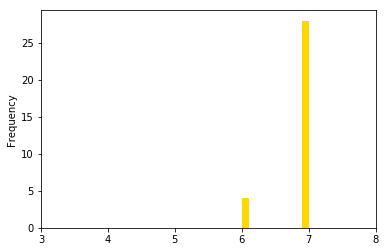

In [42]:
df_res2["worked"].plot(kind="hist", color="gold", xlim=(3,8))

##### The breakdown of shifts over nurses is much closer to the average than it was in the previous version.

### But what would be the minimal fairness level?

But what is the absolute minimum for the deviation to the ideal average number of shifts?
CPLEX can tell us: simply minimize only the the total deviation from average, ignoring the salary cost.
Of course this is unrealistic, but it will help us quantify how far our fairness result is to the
absolute optimal fairness.

We modify the objective and solve for the third time.

In [43]:
mdl.minimize(total_overw + total_underw)
assert mdl.solve(), "solve failed"
mdl.report()

* model nurses solved with objective = 4.000
*  KPI: Total salary cost  = 29576.000
*  KPI: Total over-worked  = 4.000
*  KPI: Total under-worked = 0.000


In the fairness-optimal solution, we have zero under-average shifts and 4 over-average.
Salary cost is now higher than the previous value of 28884 but this was expected as salary cost was not part of the objective.

To summarize, the absolute minimum for this measure of fairness is 4, and we have found a balance with fairness=7.

Finally, we display the histogram for this optimal-fairness solution.

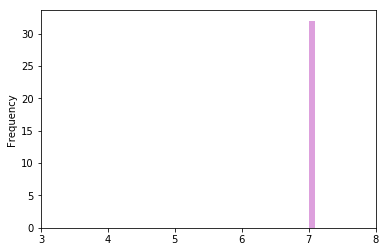

In [44]:
# Create a pandas Series containing actual shift assignment decision variables value
s_assigned_fair = df_assigned.assigned.apply(lambda v: v.solution_value)

# Create a pivot table by (nurses, shifts), using pandas' "unstack" method to transform the 'all_shifts' row index
#  into columns
df_res_fair = s_assigned_fair.unstack(level='all_shifts')

# Add a new column to the pivot table containing the #shifts worked by summing over each row
df_res_fair["solution_value_fair"] = df_res_fair[all_shifts].sum(axis=1)
df_res_fair["worked"] = df_res_fair[all_shifts].sum(axis=1)
df_res_fair["worked"].plot.hist(color="plum", xlim=(3,8))

In the above figure, all nurses but one are assigned the average of 7 shifts, which is what we expected.

## Summary

You have learned how to set up, formulate and solve an optimization model using Decision Optimization in Watson Studio.

#### References
* <a href="https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html" target="_blank" rel="noopener noreferrer">Decision Optimization CPLEX Modeling for Python documentation</a>
* <a href="https://dataplatform.cloud.ibm.com/docs/content/getting-started/welcome-main.html?audience=wdp&context=wdp" target="_blank" rel="noopener noreferrer">Watson Studio documentation</a>

Copyright © 2017-2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>